# Process RNAcompete dataset

In this noteobok, the RNAcompete dataset by (Alipahani et. al 2015, i.e. DeepBind) is preprocessed for analysis.  The sequences are converted to one-hot matrices and the targets are corrected to get rid of nan entries and normalized, either by log-normalization or by maximum/minimum clipping.

In [1]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [2]:
# load targets
filepath = '/home/peter/Data/DeepBind/rnac/'
df = pd.read_csv(os.path.join(filepath,'targets.tsv'), sep='\t')
targets = df.as_matrix()
targets = np.array(targets).astype(float)
num_data, num_labels = targets.shape

/home/peter/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,13,14,16,17,19,23,24,25,26,27,30,31,32,33,34,35,37,39,40,41,42,45,46,47,92,93,94,96,97,98,99,100,101,103,104,105,106,107,108,110,111,112,113,114,115,116,118,119,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139,140,141,142,144,145,146,147,148,149,152,153,154,155,159,160,161,162,163,164,165,166,167,168,169,172,179,180,181,187,192,193,200,208,211,212,221,223,224,227,232,235,238,239,240) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
index = np.isnan(targets)
index1, index2 = np.where(np.isnan(targets)==False)
targets[index1,index2]

array([ 1.122218,  1.272641, -1.089717, ...,  2.549737,  6.358077,
        1.825678])

In [4]:
# replace nan values with mean
mu = np.nanmean(targets, axis=0)
for i in range(num_labels):
    targets[np.isnan(targets[:,i]),i] = mu[i]

norm = 'clip'

if norm == 'log':
    # transform data to have less variance
    pos_targets = targets - np.outer(np.ones(num_data), np.nanmin(targets,axis=0)) + 1
    log_targets = np.log(pos_targets)
    log_targets -= np.outer(np.ones(num_data), np.nanmean(log_targets,axis=0))
else:
    # clip targets
    MAX = 15
    MIN = -5
    log_targets = targets
    log_targets[log_targets > MAX] = MAX
    log_targets[log_targets < MIN] = MIN

In [33]:
log_targets[3]

array([  1.38667900e+00,  -2.36797000e-01,  -3.11350000e-02,
        -9.97679000e-01,  -7.95470000e-02,   4.73447000e-01,
         6.29698100e+00,   7.87708500e+00,   1.38806880e+01,
         1.01659250e+01,  -2.48327100e+00,   8.01099000e-01,
         7.76992000e-01,  -1.30911600e+00,  -1.24247000e-01,
        -8.35040000e-01,   8.56332000e-01,  -1.66578000e-01,
        -1.89108000e-01,   4.44059000e-01,  -8.69645000e-01,
         9.63695000e-01,  -1.10783100e+00,   7.04100000e-01,
         3.37763300e+00,   7.86126000e-01,   8.43113000e-01,
         4.12906000e-01,  -1.46212800e+00,  -3.73984000e-01,
         1.16011000e-01,   3.12565000e-01,  -1.38428900e+00,
         1.73784900e+00,  -1.03130000e-02,  -4.12954000e-01,
        -7.21267000e-01,   2.43428800e+00,  -5.36923000e-01,
         1.92844000e+00,   1.34579200e+00,   1.48746200e+00,
         8.67493000e-01,   2.18673740e-01,  -2.05924000e-01,
        -8.41179000e-01,   1.66276400e+00,  -1.64914500e+00,
         1.42479700e+00,

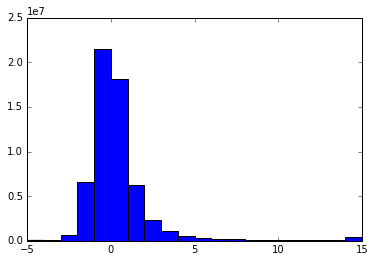

In [5]:
# plot distribution of binding affinities
index1, index2 = np.where(np.isnan(log_targets) == False)
x = np.reshape(log_targets[index1,index2],(-1,))
plt.figure()
plt.hist(x,bins=20);

In [6]:
"""
num_data = log_targets.shape[0]
num_labels = log_targets.shape[1]

mu = np.nanmean(log_targets, axis=0)
MU = np.outer(np.ones(num_data),mu)
delta = log_targets-MU
C = np.zeros((num_labels,num_labels))
for i in range(num_labels):
    index1 = np.where(np.isnan(delta[:,i])==False)[0]
    for j in range(num_labels):
        index2 = np.where(np.isnan(delta[index1,j])==False)[0]
        index = index1[index2]
        C[i,j] = np.dot(delta[index,i],delta[index,j])/len(index)
C
"""

'\nnum_data = log_targets.shape[0]\nnum_labels = log_targets.shape[1]\n\nmu = np.nanmean(log_targets, axis=0)\nMU = np.outer(np.ones(num_data),mu)\ndelta = log_targets-MU\nC = np.zeros((num_labels,num_labels))\nfor i in range(num_labels):\n    index1 = np.where(np.isnan(delta[:,i])==False)[0]\n    for j in range(num_labels):\n        index2 = np.where(np.isnan(delta[index1,j])==False)[0]\n        index = index1[index2]\n        C[i,j] = np.dot(delta[index,i],delta[index,j])/len(index)\nC\n'

In [ ]:
from six.moves import cPickle
# calculate cholesky decomposition of covariance matrix and save
L = np.linalg.cholesky(C)
Linv = np.linalg.inv(L)
f = open('/home/peter/Code/Deepomics/examples/Linv_nan.pickle','wb')
cPickle.dump(Linv, f)
cPickle.dump(C, f)
f.close()

In [ ]:
C = np.cov(log_targets.T)
plt.imshow(C)
plt.colorbar()

In [18]:
# load sequence data
df = pd.read_csv(os.path.join(filepath,'sequences.tsv'), sep='\t')
data = df.as_matrix()
foldid = data[:,0]
name = data[:,1]
sequence = data[:,2]
max_length = df.seq.str.len().max()

In [27]:
sequence[1]

'AGAGGUCGAGUAUUAGUGAUAUUAGAGUGAGGUCCAUC'

In [8]:
# loop through each label and generate a sequence 
def convert_one_hot(sequence, max_length):
    nucleotide = 'ACGU'
    one_hot_seq = []
    for seq in sequence:
        seq_length = len(seq)        
        one_hot = np.zeros((4,seq_length))
        index = [j for j in xrange(seq_length) if seq[j] == 'A']
        one_hot[0,index] = 1
        index = [j for j in xrange(seq_length) if seq[j] == 'C']
        one_hot[1,index] = 1
        index = [j for j in xrange(seq_length) if seq[j] == 'G']
        one_hot[2,index] = 1
        index = [j for j in xrange(seq_length) if seq[j] == 'U']
        one_hot[3,index] = 1
        offset1 = ((max_length - seq_length)/2).astype(int)
        offset2 = max_length - seq_length - offset1

        if offset1:
            one_hot = np.hstack([np.ones((4,offset1))/4, one_hot])
        if offset2:
            one_hot = np.hstack([one_hot, np.ones((4,offset2))/4])

        one_hot_seq.append(one_hot)

    # convert to numpy array
    one_hot_seq = np.array(one_hot_seq)
    return one_hot_seq


one_hot_seq = convert_one_hot(sequence, max_length)

In [30]:
one_hot_seq[2].T

array([[ 0.25,  0.25,  0.25,  0.25],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
 

In [10]:
def split_dataset(seq, labels, split_size):
    # generate a shuffled subset of data for train, validation, and test
    num_seq = len(seq)
    num_labels = len(np.unique(labels))
    
    cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]],num_seq)).astype(int) 
    shuffle = np.random.permutation(num_seq)
    
    train_index = shuffle[range(cum_index[0], cum_index[1])]
    valid_index = shuffle[range(cum_index[1], cum_index[2])]
    test_index = shuffle[range(cum_index[2], cum_index[3])]

    # create subsets of data based on indices 
    train = (seq[train_index], labels[train_index])
    valid = (seq[valid_index], labels[valid_index])
    test = (seq[test_index], labels[test_index])
    
    return train, valid, test
    
# split dataset into training cross validation and testing
train_size = 0.7
valid_size = 0.15
test_size = 0.15
split_size = [train_size, valid_size, test_size]
train, valid, test = split_dataset(one_hot_seq, log_targets, split_size)

In [11]:
def save_dataset(savepath, train, valid, test):
    f = h5py.File(savepath, "w")
    dset = f.create_dataset("trainx", data=train[0])
    dset = f.create_dataset("trainy", data=train[1])
    dset = f.create_dataset("validx", data=valid[0])
    dset = f.create_dataset("validy", data=valid[1])
    dset = f.create_dataset("testx", data=test[0])
    dset = f.create_dataset("testy", data=test[1])
    f.close()

savename = "rnac.hdf5"
save_dataset(os.path.join(filepath,savename), train, valid, test)

In [13]:
train[0]

array([[[ 0.25,  1.  ,  0.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  1.  , ...,  1.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  0.  ,  0.25,  0.25]],

       [[ 0.25,  1.  ,  0.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  1.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  1.  ,  0.25,  0.25]],

       [[ 0.25,  1.  ,  0.  , ...,  1.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  1.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  0.  ,  0.25,  0.25]],

       ..., 
       [[ 0.25,  1.  ,  0.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  1.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  1.  , ...,  0.  ,  0.25,  0.25],
        [ 0.25,  0.  ,  0.  , ...,  0.  ,  0.25,  0.25]],

       [[ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
        [ 

In [34]:
os.path.join(filepath,savename)

'/home/peter/Data/DeepBind/rnac/rnac.hdf5'